# **IMPORT MODULES/FUNCTIONS/LOAD DATA**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

from efficient_kan.src.efficient_kan import KAN
#from faster_kan.fastkan.fastkan import FastKAN
#from kan import *
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
from functions import get_mean_pulse_from_set, momentos, gauss, gauss_fit, move_to_reference, create_and_delay_pulse_pair, create_position, set_seed, calculate_gaussian_center_sigma, normalize, normalize_given_params, plot_gaussian_and_get_params
from functions_KAN import n_params_KAN, train_loop_KAN

In [3]:
V55 = np.load('/home/josea/Co60_5cm_5cm.npy')
V28 = np.load('/home/josea/Co60_2cm_8cm.npy')
V82 = np.load('/home/josea/Co60_8cm_2cm.npy')

#V28 = np.load('/home/josea/TFM_Alba_Co60_2cm_8cm_fullgate_polyfit.npz')['data']
#V55 = np.load('/home/josea/TFM_Alba_Co60_5cm_5cm_fullgate_polyfit.npz')['data']
#V82 = np.load('/home/josea/TFM_Alba_Co60_8cm_2cm_fullgate_polyfit.npz')['data']
REALS = np.concatenate((V28, V55, V82), axis = 0)


#data = np.load('/home/josea/pulsos_Co60_filt_norm_5k_polyfit.npz')['data']
data = np.load('/home/josea/PRUEBA_Co60.npz')['data']
#data = np.load('/home/josea/pulsos_Na22_filt_norm_practica_polyfit.npz')['data']

# **INTERPOLATION**

In [4]:
#--------------------------------Interpolar pulsos reales---------------------------------
EXTRASAMPLING = 8
Nt = np.shape(data)[1]
Nt_new = Nt *  EXTRASAMPLING
time_step = 0.2
new_time_step = time_step / EXTRASAMPLING

tiempo = np.linspace(0, Nt, Nt)
tiempo_new = np.linspace(0,Nt,Nt_new)

interp_func_REALS = interp1d(tiempo, REALS, kind = 'cubic', axis = 1)
new_REALS = interp_func_REALS(tiempo_new)

interp_func_data = interp1d(tiempo, data, kind = 'cubic', axis = 1)
new_data = interp_func_data(tiempo_new)


#--------------------------------------- Align the pulses -----------------------------------
align_steps = 20
new_data[:,:,1] = np.roll(new_data[:,:,1], align_steps)
new_data[:,:align_steps,1] = np.random.normal(scale = 1e-3, size = align_steps)

print('Number of time points: %.d' % (Nt))
print('Time step: %.2f' % (time_step))
print('New number of time points: %.d' % (Nt_new))
print('New time step: %.4f' % (new_time_step))

Number of time points: 600
Time step: 0.20
New number of time points: 4800
New time step: 0.0250


# **IMPORTANT DEFINITIONS**

In [5]:
ajuste_grueso = 1  # 0 = YES, 1 = NO
delay_steps = 30  # Max number of steps to delay pulses
moments_order = 5  # Max order of moments used
set_seed(42) #Fix seeds
nbins = 51 #Num bins for all histograms
create_positions = 0 # Wether to create new_source positions. (0 = YES, 1 = NO)                           
t_shift = 8 #Time steps to move for the new positions
normalization_method = 'min-max'
start = 50*EXTRASAMPLING 
stop = 74*EXTRASAMPLING 


# Train/test set split
train_data = new_data[:3800,:,:]
test_data = new_data[3800:,:,:] 
print('Número de casos de entrenamiento: ', train_data.shape[0])
print('Número de casos de test: ', test_data.shape[0])

Número de casos de entrenamiento:  3800
Número de casos de test:  656


# **DETECTORS**

In [6]:
# Create train set 
if ajuste_grueso == 0:
    
    mean_pulse_dec0 = get_mean_pulse_from_set(train_data, channel = 0)
    mean_pulse_dec1 = get_mean_pulse_from_set(train_data, channel = 1)

    # Move pulses to align with mean and then delay them 
    delays2_dec0, moved_pulses2_dec0 = move_to_reference(mean_pulse_dec0, train_data, start = start, stop = stop, max_delay = int(stop-start), channel = 0)
    delays2_dec1, moved_pulses2_dec1 = move_to_reference(mean_pulse_dec1, train_data, start = start, stop = stop, max_delay = int(stop-start), channel = 1)
    
    trainX_dec0, REF_train_dec0 = create_and_delay_pulse_pair(moved_pulses2_dec0, new_time_step, delay_steps = delay_steps, NOISE = False)
    trainX_dec1, REF_train_dec1 = create_and_delay_pulse_pair(moved_pulses2_dec1, new_time_step, delay_steps = delay_steps, NOISE = False)


if ajuste_grueso == 1:

    trainX_dec0, REF_train_dec0 = create_and_delay_pulse_pair(train_data[:,start:stop,0], new_time_step, delay_steps = delay_steps, NOISE = False)
    trainX_dec1, REF_train_dec1 = create_and_delay_pulse_pair(train_data[:,start:stop,1], new_time_step, delay_steps = delay_steps, NOISE = False)

Text(0.5, 1.0, 'Detector 1')

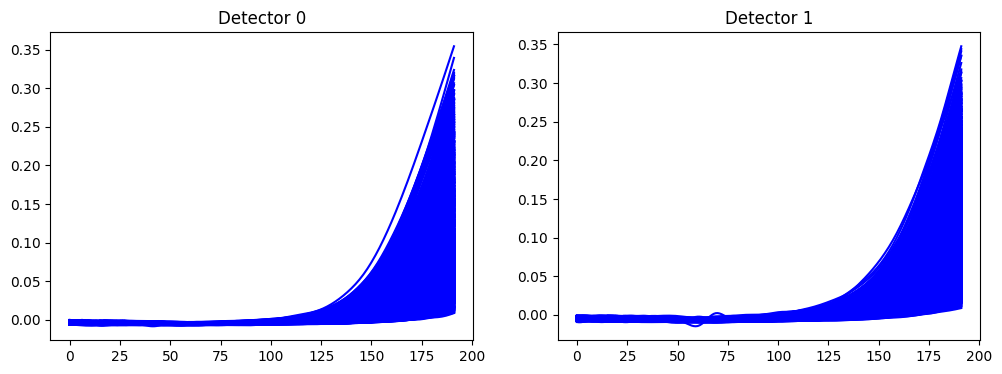

In [7]:
plt.figure(figsize = (12,4))

plt.subplot(121)
for i in range(trainX_dec0.shape[0]):
    plt.plot(trainX_dec0[i,:,0],'b-')
plt.title('Detector 0')

plt.subplot(122)
for i in range(trainX_dec1.shape[0]):
    plt.plot(trainX_dec1[i,:,0],'b-')
plt.title('Detector 1')

In [8]:
#-------------------------------------------------------------- Calculate moments ---------------------------------------------------
M_Train_dec0 = momentos(trainX_dec0, order = moments_order) 
M_Train_dec1 = momentos(trainX_dec1, order = moments_order) 

#-------------------------------------------------------------- Normalize ---------------------------------------------------
M_Train_dec0, params_dec0 =  normalize(M_Train_dec0, method = normalization_method)
M_Train_dec1, params_dec1 =  normalize(M_Train_dec1, method = normalization_method)

#-------------------------------------------------------------- Print information ---------------------------------------------------
NM = np.shape(M_Train_dec0)[1]
print(M_Train_dec0.shape, "NM =", NM)
print("Normalization parameters detector 0:", params_dec0)

NM = np.shape(M_Train_dec1)[1]
print(M_Train_dec1.shape, "NM =", NM)
print("Normalization parameters detector 1:", params_dec1)

(3800, 5, 2) NM = 5
Normalization parameters detector 0: (array([-0.59037584, -0.21703806, -0.08446715, -0.02463465,  0.00732137]), array([9.21233292, 8.53048929, 7.76744566, 7.09737441, 6.52248194]))
(3800, 5, 2) NM = 5
Normalization parameters detector 1: (array([-0.75035392, -0.27204374, -0.11697501, -0.04513164, -0.0047014 ]), array([8.20157933, 7.71131143, 7.06060839, 6.47540144, 5.96932863]))


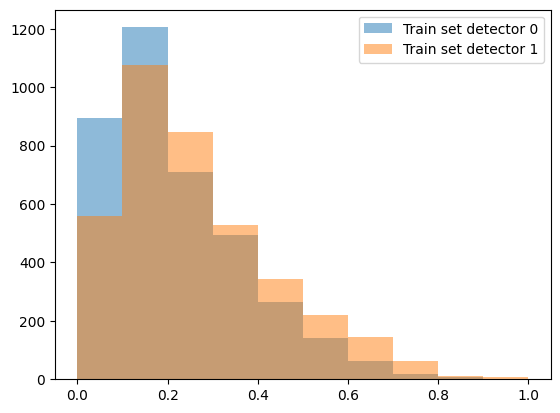

In [9]:
plt.hist(M_Train_dec0[:,0,0], alpha = 0.5, label = 'Train set detector 0');
plt.hist(M_Train_dec1[:,0,0], alpha = 0.5, label = 'Train set detector 1');
plt.legend()

# **FULL TOF (KAN)**

In [10]:
#-------------------------------- Create test set ---------------------------------------------------------
if ajuste_grueso == 0:
    delays_test_dec0, moved_pulses_test_dec0 = move_to_reference(mean_pulse_dec0, test_data, start = start, stop = stop, max_delay = int(stop-start), channel = 0)
    delays_test_dec1, moved_pulses_test_dec1 = move_to_reference(mean_pulse_dec1, test_data, start = start, stop = stop, max_delay = int(stop-start), channel = 1)
    
    if create_positions == 1:
        TEST = np.stack((moved_pulses_test_dec0, moved_pulses_test_dec1), axis = 2)

    if create_positions == 0:
        TEST_00 = np.stack((moved_pulses_test_dec0, moved_pulses_test_dec1), axis = 2)
        TEST_02 = create_position(TEST_00, channel_to_move = 1, channel_to_fix = 0, t_shift = t_shift, NOISE = False)
        TEST_20 = create_position(TEST_00, channel_to_move = 0, channel_to_fix = 1, t_shift = t_shift, NOISE = False)
        TEST_04 = create_position(TEST_00, channel_to_move = 1, channel_to_fix = 0, t_shift = int(2*t_shift), NOISE = False)
        TEST_40 = create_position(TEST_00, channel_to_move = 0, channel_to_fix = 1, t_shift = int(2*t_shift), NOISE = False)
        TEST = np.concatenate((TEST_02, TEST_00, TEST_20, TEST_04, TEST_40), axis = 0)

if ajuste_grueso == 1:
    
    if create_positions == 1:
        TEST = test_data[:,start:stop,:]
    
    if create_positions == 0:
        TEST_00 = test_data[:,start:stop,:] 
        TEST_02 = create_position(TEST_00, channel_to_move = 1, channel_to_fix = 0, t_shift = t_shift, NOISE = False)
        TEST_20 = create_position(TEST_00, channel_to_move = 0, channel_to_fix = 1, t_shift = t_shift, NOISE = False)
        TEST_04 = create_position(TEST_00, channel_to_move = 1, channel_to_fix = 0, t_shift = int(2*t_shift), NOISE = False)
        TEST_40 = create_position(TEST_00, channel_to_move = 0, channel_to_fix = 1, t_shift = int(2*t_shift), NOISE = False)
        TEST = np.concatenate((TEST_02, TEST_00, TEST_20, TEST_04, TEST_40), axis = 0)



MOMENTS_TEST = momentos(TEST, order = moments_order)
MOMENTS_TEST_norm_dec0 = normalize_given_params(MOMENTS_TEST, params_dec0, channel = 0, method = normalization_method)
MOMENTS_TEST_norm_dec1 = normalize_given_params(MOMENTS_TEST, params_dec1, channel = 1, method = normalization_method)
MOMENTS_TEST = np.stack((MOMENTS_TEST_norm_dec0, MOMENTS_TEST_norm_dec1), axis = -1)

In [11]:
# Define model parameters
architecture = [NM, NM*2, 1, 1]   
grid_size = 5   # Efficient KAN uses grid size 5
k_order = 3

# Initialize model
#model_dec0 = KAN(width = architecture, grid = grid_size, k = k_order, seed = 0)
#model_dec1 = KAN(width = architecture, grid = grid_size, k = k_order, seed = 0)

model_dec0 = KAN(architecture)
model_dec1 = KAN(architecture)
         
n_params = n_params_KAN(architecture, grid_size, k_order)
print('Number of parameters for this architecture:', n_params) #Se calcula el número de parametros igual en efficient kan?

Number of parameters for this architecture: 488


In [12]:
# Create Dataset
train_dataset_dec0 = torch.utils.data.TensorDataset(torch.from_numpy(M_Train_dec0).float(), torch.from_numpy(np.expand_dims(REF_train_dec0, axis = -1)).float())
train_dataset_dec1 = torch.utils.data.TensorDataset(torch.from_numpy(M_Train_dec1).float(), torch.from_numpy(np.expand_dims(REF_train_dec1, axis = -1)).float())

# Create DataLoaders
train_loader_dec0 = torch.utils.data.DataLoader(train_dataset_dec0, batch_size = 32, shuffle = True)
train_loader_dec1 = torch.utils.data.DataLoader(train_dataset_dec1, batch_size = 32, shuffle = True)

optimizer_dec0 = torch.optim.AdamW(model_dec0.parameters(), lr = 1e-3) #Regularization?
optimizer_dec1 = torch.optim.AdamW(model_dec1.parameters(), lr = 1e-3)  #3e-3 

In [13]:
# Execute train l0op
loss_dec0, test_dec0 = train_loop_KAN(model_dec0, optimizer_dec0, train_loader_dec0, torch.tensor(MOMENTS_TEST[:,:,0]).float(), EPOCHS = 1000, save = False) 
loss_dec1, test_dec1 = train_loop_KAN(model_dec1, optimizer_dec1, train_loader_dec1, torch.tensor(MOMENTS_TEST[:,:,1]).float(), EPOCHS = 1000, save = False)

EPOCH 1:
LOSS train 0.09339787769999544
EPOCH 2:
LOSS train 0.08917069318309678
EPOCH 3:
LOSS train 0.04511532174044494
EPOCH 4:
LOSS train 0.004443478724678537
EPOCH 5:
LOSS train 0.0021169723120815975
EPOCH 6:
LOSS train 0.0013768994540441781
EPOCH 7:
LOSS train 0.0010089819895210124
EPOCH 8:
LOSS train 0.0008986670093737163
EPOCH 9:
LOSS train 0.0006589437951457142
EPOCH 10:
LOSS train 0.00047340275982682894
EPOCH 11:
LOSS train 0.0003635663314973067
EPOCH 12:
LOSS train 0.0003232964185896227
EPOCH 13:
LOSS train 0.0002335881466224545
EPOCH 14:
LOSS train 0.0002081912070164019
EPOCH 15:
LOSS train 0.00019121921382142998
EPOCH 16:
LOSS train 0.0001792313168599799
EPOCH 17:
LOSS train 0.0001789757341118845
EPOCH 18:
LOSS train 0.00016556647883050372
EPOCH 19:
LOSS train 0.0001605461353793251
EPOCH 20:
LOSS train 0.0001562276709406988
EPOCH 21:
LOSS train 0.00014901932500849352
EPOCH 22:
LOSS train 0.00014978525022173525
EPOCH 23:
LOSS train 0.00014883263287690895
EPOCH 24:
LOSS train 

In [14]:
if ajuste_grueso == 0:

    if create_positions == 1:
        TOFN = (test_dec0 - new_time_step*delays_test_dec0) - (test_dec1 - new_time_step*delays_test_dec1)
        TOFN_V28 = TOFN[:,:V28.shape[0]] - test_dec1[:,: V28.shape[0]]
        TOFN_V55 = TOFN[:,V28.shape[0] : V28.shape[0] + V55.shape[0]]  - test_dec1[:,V28.shape[0] :V28.shape[0] + V55.shape[0]] 
        TOFN_V82 = TOFN[:,V28.shape[0] + V55.shape[0]:] - test_dec1[:,V28.shape[0] + V55.shape[0]:] 
    
    if create_positions == 0:
        TOFN_V02 = (test_dec0[:,:TEST_00.shape[0]] - new_time_step*delays_test_dec0) - (test_dec1[:,:TEST_00.shape[0]] - new_time_step*delays_test_dec1)
        TOFN_V00 = (test_dec0[:,TEST_00.shape[0] : 2*TEST_00.shape[0]] - new_time_step*delays_test_dec0) - (test_dec1[:,TEST_00.shape[0] : 2*TEST_00.shape[0]] - new_time_step*delays_test_dec1)
        TOFN_V20 = (test_dec0[:,2*TEST_00.shape[0] :3*TEST_00.shape[0]]  - new_time_step*delays_test_dec0) - (test_dec1[:,2*TEST_00.shape[0] :3*TEST_00.shape[0]] - new_time_step*delays_test_dec1)
        TOFN_V04 = (test_dec0[:,3*TEST_00.shape[0] :4*TEST_00.shape[0]]  - new_time_step*delays_test_dec0) - (test_dec1[:,3*TEST_00.shape[0] :4*TEST_00.shape[0]] - new_time_step*delays_test_dec1)
        TOFN_V40 = (test_dec0[:,4*TEST_00.shape[0]:]  - new_time_step*delays_test_dec0) - (test_dec1[:,4*TEST_00.shape[0]:] - new_time_step*delays_test_dec1)
    
if ajuste_grueso == 1:
    
    if create_positions == 1:
        TOFN_V28 = test_dec0[:,:V28.shape[0]] - test_dec1[:,:V28.shape[0]]
        TOFN_V55 = test_dec0[:,V28.shape[0] :V28.shape[0] + V55.shape[0]] - test_dec1[:,V28.shape[0] :V28.shape[0] + V55.shape[0]]
        TOFN_V82 = test_dec0[:,V28.shape[0] + V55.shape[0]:] - test_dec1[:,V28.shape[0] + V55.shape[0]:]

    if create_positions == 0:
        TOFN_V02 = test_dec0[:,:TEST_00.shape[0]] - test_dec1[:,:TEST_00.shape[0]]
        TOFN_V00 = test_dec0[:,TEST_00.shape[0] : 2*TEST_00.shape[0]] - test_dec1[:, TEST_00.shape[0] : 2*TEST_00.shape[0]]
        TOFN_V20 = test_dec0[:,2*TEST_00.shape[0] :3*TEST_00.shape[0]] - test_dec1[:,2*TEST_00.shape[0] :3*TEST_00.shape[0]]
        TOFN_V04 = test_dec0[:,3*TEST_00.shape[0] :4*TEST_00.shape[0]] - test_dec1[:,3*TEST_00.shape[0] :4*TEST_00.shape[0]]
        TOFN_V40 = test_dec0[:,4*TEST_00.shape[0]:] - test_dec1[:,4*TEST_00.shape[0]:]
    

# Calulate Validation error
if create_positions == 1:
    
    # Calculate centered position 'centroid'
    centroid_V55, sigmaN_V55 = calculate_gaussian_center_sigma(TOFN_V55, np.zeros((TOFN_V55.shape[0])), hist_range = 2,  nbins = nbins)  
    
    error_V28 = abs((TOFN_V28 - centroid_V55[:, np.newaxis] + 0.2))
    error_V55 = abs((TOFN_V55 - centroid_V55[:, np.newaxis]))
    error_V82 = abs((TOFN_V82 - centroid_V55[:, np.newaxis] - 0.2))
    Error = np.concatenate((error_V28, error_V55, error_V82), axis = 1)

if create_positions == 0:

    # Calculate centered position 'centroid'
    centroid_V00, sigmaN_V00 = calculate_gaussian_center_sigma(TOFN_V00, np.zeros((TOFN_V00.shape[0])), hist_range = 2, nbins = nbins) 

    error_V02 = abs((TOFN_V02 - centroid_V00[:, np.newaxis] + 0.2))
    error_V00 = abs((TOFN_V00 - centroid_V00[:, np.newaxis]))
    error_V20 = abs((TOFN_V20 - centroid_V00[:, np.newaxis] - 0.2))
    error_V04 = abs((TOFN_V04 - centroid_V00[:, np.newaxis] + 0.4))
    error_V40 = abs((TOFN_V40 - centroid_V00[:, np.newaxis] - 0.4))

    Error = np.concatenate((error_V02, error_V00, error_V20, error_V04, error_V40), axis = 1)   

/home/josea/DEEP_TIMING/DEEP_TIMING_VS/functions.py:40: RuntimeWarning: divide by zero encountered in divide
  return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))
/home/josea/DEEP_TIMING/DEEP_TIMING_VS/functions.py:40: RuntimeWarning: invalid value encountered in divide
  return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))
/home/josea/DEEP_TIMING/DEEP_TIMING_VS/functions.py:45: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])


944 0.05030805959923691


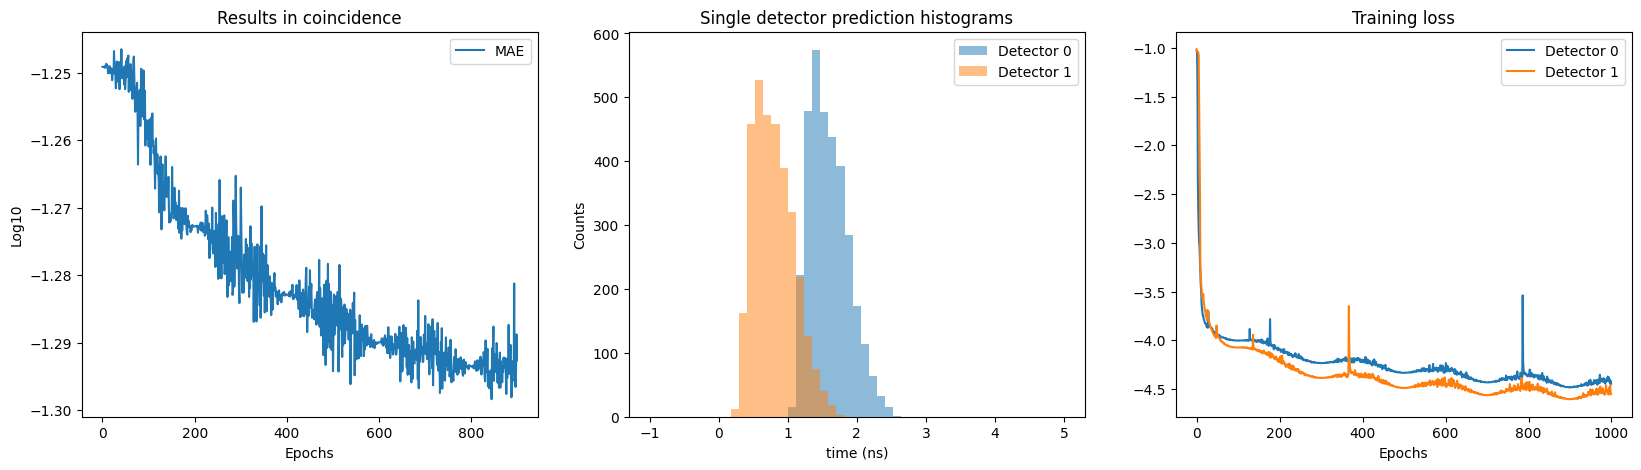

In [15]:
# Print MAE
MAE = np.mean(Error, axis = 1)
idx_min_MAE = np.where(MAE == np.min(MAE))[0][0]
print(idx_min_MAE, np.min(MAE))


# PLot
plt.figure(figsize = (20,5))
plt.subplot(131)
plt.plot(np.log10(MAE[100:].astype('float64')), label = 'MAE')
plt.title('Results in coincidence')
plt.xlabel('Epochs')
plt.ylabel('Log10')
plt.legend()

plt.subplot(132)
if ajuste_grueso == 0:
    plt.hist(test_dec0[idx_min_MAE , :delays_test_dec0.shape[0]] - new_time_step*delays_test_dec0, bins = nbins, range = [-1, 3], alpha = 0.5, label = 'Detector 0');
    plt.hist(test_dec1[idx_min_MAE , :delays_test_dec1.shape[0]] - new_time_step*delays_test_dec1, bins = nbins, range = [-1, 3], alpha = 0.5, label = 'Detector 1');

if ajuste_grueso == 1:
    plt.hist(test_dec0[idx_min_MAE , :], bins = nbins, range = [-1, 5], alpha = 0.5, label = 'Detector 0');
    plt.hist(test_dec1[idx_min_MAE , :], bins = nbins, range = [-1, 5], alpha = 0.5, label = 'Detector 1');

plt.title('Single detector prediction histograms')
plt.xlabel('time (ns)')
plt.ylabel('Counts')
plt.legend()

plt.subplot(133)
plt.plot(np.log10(loss_dec0.astype('float32')), label = 'Detector 0')
plt.plot(np.log10(loss_dec1.astype('float32')), label = 'Detector 1')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.legend()


V40: CENTROID(ns) = 0.393  FWHM(ns) = 0.149  std(ns) = 0.063
V82: CENTROID(ns) = 0.194  FWHM(ns) = 0.147  std(ns) = 0.062
V55: CENTROID(ns) = -0.001  FWHM(ns) = 0.149  std(ns) = 0.063
V28: CENTROID(ns) = -0.199  FWHM(ns) = 0.148  std(ns) = 0.063
V04: CENTROID(ns) = -0.401  FWHM(ns) = 0.149  std(ns) = 0.063


Text(0, 0.5, 'Counts')

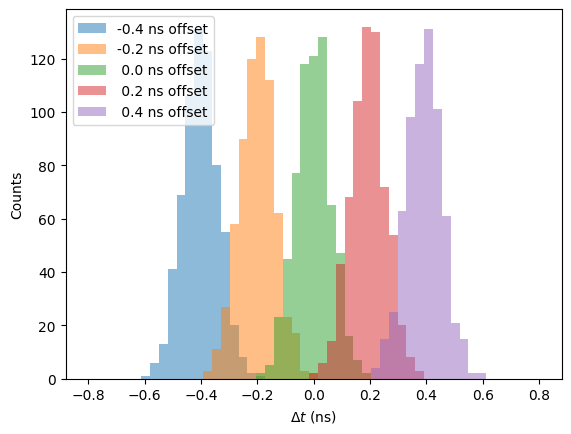

In [16]:
epoch = idx_min_MAE
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
if create_positions == 0:
    HN, AN, x0N_V04, sigmaN_V04, FWHMN_V04 = plot_gaussian_and_get_params(TOFN_V04[epoch,:], centroid_V00[epoch], range = 0.8, label = '-0.4 ns offset', nbins = nbins)
    HN, AN, x0N_V28, sigmaN_V28, FWHMN_V28 = plot_gaussian_and_get_params(TOFN_V02[epoch,:], centroid_V00[epoch], range = 0.8, label = '-0.2 ns offset', nbins = nbins)
    HN, AN, x0N_V55, sigmaN_V55, FWHMN_V55 = plot_gaussian_and_get_params(TOFN_V00[epoch,:], centroid_V00[epoch], range = 0.8, label = ' 0.0 ns offset', nbins = nbins)
    HN, AN, x0N_V82, sigmaN_V82, FWHMN_V82 = plot_gaussian_and_get_params(TOFN_V20[epoch,:], centroid_V00[epoch], range = 0.8, label = ' 0.2 ns offset', nbins = nbins)
    HN, AN, x0N_V40, sigmaN_V40, FWHMN_V40 = plot_gaussian_and_get_params(TOFN_V40[epoch,:], centroid_V00[epoch], range = 0.8, label = ' 0.4 ns offset', nbins = nbins)

    print('')
    print("V40: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V40, FWHMN_V40, sigmaN_V40))
    print("V82: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V82, FWHMN_V82, sigmaN_V82))
    print("V55: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V55, FWHMN_V55, sigmaN_V55))
    print("V28: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V28, FWHMN_V28, sigmaN_V28))
    print("V04: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V04, FWHMN_V04, sigmaN_V04))

if create_positions == 1:
    HN, AN, x0N_V28, sigmaN_V28, FWHMN_V28 = plot_gaussian_and_get_params(TOFN_V28[epoch,:], centroid_V55[epoch], range = 0.8, label = '-0.2 ns offset', nbins = nbins)
    HN, AN, x0N_V55, sigmaN_V55, FWHMN_V55 = plot_gaussian_and_get_params(TOFN_V55[epoch,:], centroid_V55[epoch], range = 0.8, label = ' 0.0 ns offset', nbins = nbins)
    HN, AN, x0N_V82, sigmaN_V82, FWHMN_V82 = plot_gaussian_and_get_params(TOFN_V82[epoch,:], centroid_V55[epoch], range = 0.8, label = ' 0.2 ns offset', nbins = nbins)
   

    print('')
    print("V82: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V82, FWHMN_V82, sigmaN_V82))
    print("V55: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V55, FWHMN_V55, sigmaN_V55))
    print("V28: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V28, FWHMN_V28, sigmaN_V28))

plt.legend()
plt.xlabel('$\Delta t$ (ns)')
plt.ylabel('Counts')

In [17]:
import time

time_test = np.tile(trainX_dec0[0,:,:], (1000000, 1,1))

# Start timer moments
start_time_momentos = time.time()
M_time_test = momentos(time_test, order = moments_order)
end_time_momentos = time.time()


# Start timer inference
start_time_inference= time.time()
with torch.no_grad():
    assert not torch.is_grad_enabled()
    output_time_test = model_dec0(torch.tensor(M_time_test[:,:,0]).float())
end_time_inference = time.time()

# Calculate the elapsed times
elapsed_time_momentos = end_time_momentos - start_time_momentos
elapsed_time_inference = end_time_inference - start_time_inference

print(f"Elapsed time momentos: {elapsed_time_momentos} seconds")
print(f"Elapsed time inference: {elapsed_time_inference} seconds")

Elapsed time momentos: 15.125338792800903 seconds
Elapsed time inference: 1.1000049114227295 seconds


Text(0, 0.5, 'Absolute error')

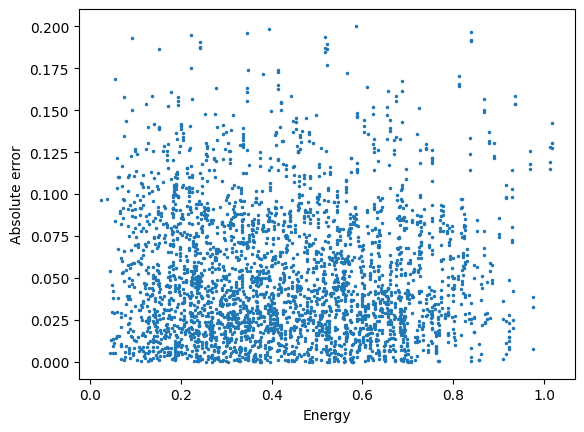

In [18]:
energy = MOMENTS_TEST[:,0,:]

plt.plot(energy[:,1], Error[epoch,:], 'o', markersize = 1.5)
plt.xlabel('Energy')
plt.ylabel('Absolute error')